In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, LassoCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from numpy import sqrt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde

#library to create the pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
import patsy
import patsylearn

from sklearn.base import BaseEstimator, TransformerMixin
#see parsytransformer.py
from my_transformers import FormulaTransformer
from my_transformers import NoTransformer
from my_transformers import Float16Transformer, Float32Transformer
from my_transformers import DFTransformer
from my_transformers import ColNameTransformer, ColNameTransformer2

#to save and load the pipeline and model fitted in a pickle (.pkl) file
import pickle
import patsy

In [58]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [59]:
def preprepros(df):   
    df_test = pd.read_csv('test.csv')
    df.shape
    df = df.dropna()
    df = df.drop_duplicates()
    df.loc[df['lot_size_units'] == 'acre', 'lot_size'] = df.loc[df['lot_size_units'] == 'acre', 'lot_size'] * 43560
    df.loc[df['size_units'] == 'acre', 'size'] = df.loc[df['size_units'] == 'acre', 'size'] * 43560
    df = df[df['lot_size'] < 1000000]
    df = df[df['price'] < 10000000]
    list_zip = [98144, 98106, 98107, 98199, 98133, 98105, 98108,
       98178, 98103, 98177, 98115, 98119, 98117, 98116,
       98146, 98125, 98126, 98118, 98109, 98112, 98136,
       98122, 98168, 98102, 98121, 98101, 98104]
    df = df.query('zip_code in @list_zip')
    df['zip_code'] = df['zip_code'].astype(str)
    df = df.reset_index()
    df = df.drop(columns = ['index'])
    
    return df 

In [60]:
df_train  = preprepros(df_train)

df_test  = preprepros(df_test)

/tmp/ipykernel_1648/1301583074.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zip_code'] = df['zip_code'].astype(str)


In [61]:
df_train

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.0,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,13503.6,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.0,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.0,sqft,98199,1950000.0
4,2,2.0,1190.0,sqft,43560.0,acre,98107,740000.0
...,...,...,...,...,...,...,...,...
1651,3,3.5,1680.0,sqft,1486.0,sqft,98126,675000.0
1652,2,2.0,1400.0,sqft,14810.4,acre,98199,699950.0
1653,3,2.0,1370.0,sqft,21780.0,acre,98112,910000.0
1654,4,2.0,2140.0,sqft,6250.0,sqft,98199,1150000.0


In [62]:
df_train.head(5)

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.0,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,13503.6,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.0,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.0,sqft,98199,1950000.0
4,2,2.0,1190.0,sqft,43560.0,acre,98107,740000.0


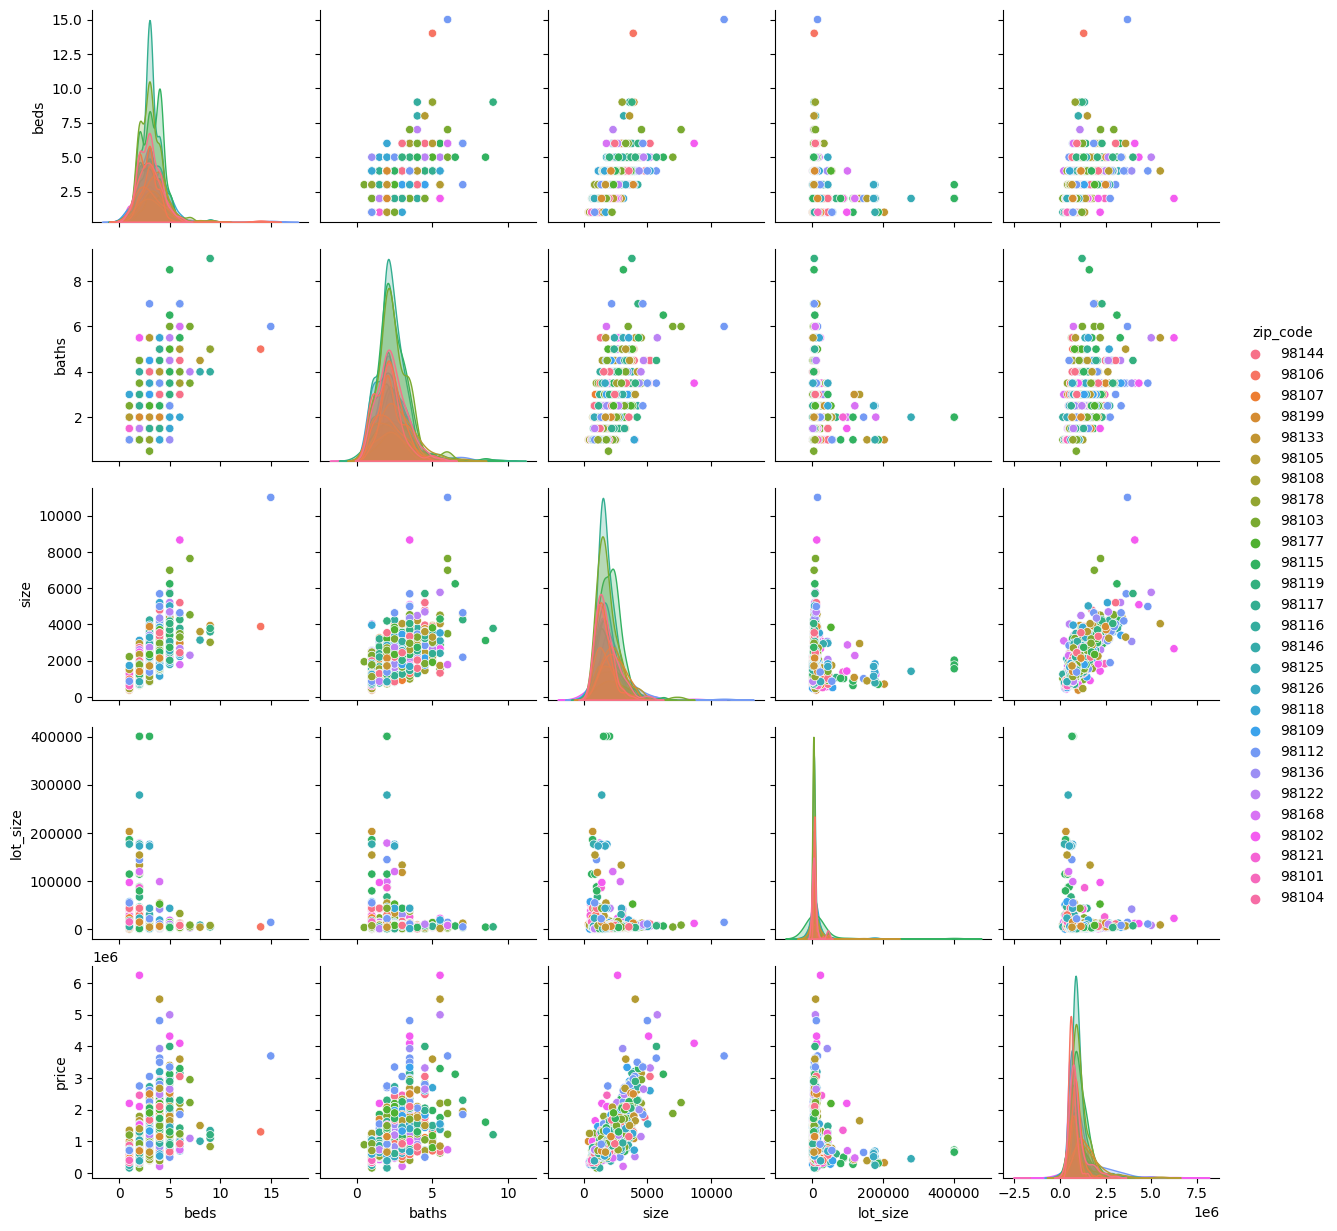

In [63]:
sns.pairplot(df_train, hue ='zip_code')
plt.show()

In [41]:
formula = 'beds * baths * size * zip_code'

In [64]:
cat_columns = ['zip_code']
num_columns = ['beds', 'baths', 'size']

In [65]:
y_train = df_train['price']
X_train = df_train.drop(columns = ['price'])
y_test = df_test['price']
X_test = df_test.drop(columns = ['price'])

<h1>LinearModel</h1>

In [66]:
num_pipeline = Pipeline([
    ('simple_imp', SimpleImputer(strategy="median")),
    ('pt', PowerTransformer(standardize=False)),
    ('MMScaler', MinMaxScaler(feature_range=(0.1, 1), clip = True))
    ])

preprocessor = ColumnTransformer([('num_transform', num_pipeline, num_columns),
                                ('NoTransformer', NoTransformer(), cat_columns),
                                ])

workflow = make_pipeline(preprocessor, 
                         DFTransformer(),
                         ColNameTransformer(),
                         Float16Transformer(),
                         patsylearn.PatsyTransformer(formula, add_intercept=True),
                         LinearRegression())

set_config(display="diagram")

workflow

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('simple_imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('pt',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('MMScaler',
                                                                   MinMaxScaler(clip=True,
                                                                                feature_range=(0.1,
                                                                                               1)))]),
                                                  ['beds', 'baths', 'size']),
                                                 ('NoTransformer',
                                                  NoTransformer(),
                                                  ['zip_code'])])),
                ('dftransformer', DFTransformer()),
                ('colnametransformer', ColNameTransformer()),
                ('float16transformer', Float16Transformer()),
                ('patsytransformer',
                 PatsyTransformer(add_intercept=True,
                                  formula='beds * baths * size * zip_code')),
                ('linearregression', LinearRegression())])

In [67]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train  = preprepros(df_train)
df_test  = preprepros(df_test)

y_train = df_train['price']
X_train = df_train.drop(columns = ['price'])
y_test = df_test['price']
X_test = df_test.drop(columns = ['price'])

/tmp/ipykernel_1648/1301583074.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zip_code'] = df['zip_code'].astype(str)


In [68]:
df_test

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,3.0,2850.0,sqft,4200.0,sqft,98119,1175000.0
1,4,5.0,3040.0,sqft,5002.0,sqft,98106,1057500.0
2,3,1.0,1290.0,sqft,6048.0,sqft,98125,799000.0
3,3,3.5,1942.0,sqft,1603.0,sqft,98107,1187000.0
4,2,2.0,963.0,sqft,4753.0,sqft,98122,701000.0
...,...,...,...,...,...,...,...,...
421,5,4.5,5580.0,sqft,13068.0,acre,98146,3800000.0
422,3,2.5,1390.0,sqft,1570.0,sqft,98126,575000.0
423,3,2.5,2950.0,sqft,20473.2,acre,98118,3105000.0
424,5,5.0,3010.0,sqft,4887.0,sqft,98115,1807000.0


In [69]:
lm = workflow.fit(X_train, y_train)

In [70]:
lm.score(X_test, y_test)

0.5904447373347296

<h1>Ridge</h1>

In [71]:
num_pipeline = Pipeline([
    ('simple_imp', SimpleImputer(strategy="median")),
    ('pt', PowerTransformer(standardize=False)),
    ('MMScaler', MinMaxScaler(feature_range=(0.1, 1), clip = True))
    ])

preprocessor = ColumnTransformer([('num_transform', num_pipeline, num_columns),
                                ('NoTransformer', NoTransformer(), cat_columns),
                                ])

workflow = make_pipeline(preprocessor, 
                         DFTransformer(),
                         ColNameTransformer(),
                         Float16Transformer(),
                         patsylearn.PatsyTransformer(formula, add_intercept=True)
                         )

set_config(display="diagram")

workflow

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('simple_imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('pt',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('MMScaler',
                                                                   MinMaxScaler(clip=True,
                                                                                feature_range=(0.1,
                                                                                               1)))]),
                                                  ['beds', 'baths', 'size']),
                                                 ('NoTransformer',
                                                  NoTransformer(),
                                                  ['zip_code'])])),
                ('dftransformer', DFTransformer()),
                ('colnametransformer', ColNameTransformer()),
                ('float16transformer', Float16Transformer()),
                ('patsytransformer',
                 PatsyTransformer(add_intercept=True,
                                  formula='beds * baths * size * zip_code'))])

In [72]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train  = preprepros(df_train)
df_test  = preprepros(df_test)

y_train = df_train['price']
X_train = df_train.drop(columns = ['price'])
y_test = df_test['price']
X_test = df_test.drop(columns = ['price'])

/tmp/ipykernel_1648/1301583074.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zip_code'] = df['zip_code'].astype(str)


In [73]:
workflow.fit(X_train)
X_train = workflow.transform(X_train)
X_test = workflow.transform(X_test)

param = {'alpha' : [i/1000 for i in range(1, 500, 1)]}
grid_ridge = GridSearchCV(Ridge(), param, cv = 5, pre_dispatch = 5).fit(X_train, y_train)
grid_ridge.best_estimator_.score(X_test, y_test)

0.6153116713034816

In [102]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_ridge.best_estimator_,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="r2",
    train_sizes = [5, 50, 100, 500, 600, 1000, 1200, 1324]
)

In [103]:
train_scores

array([[0.9999968 , 0.99999739, 0.99999739, 0.99999739, 0.99999739],
       [0.97926099, 0.99311383, 0.99311383, 0.99311383, 0.99311383],
       [0.93727853, 0.9664227 , 0.9664227 , 0.9664227 , 0.9664227 ],
       [0.82022067, 0.82822521, 0.81739324, 0.81739324, 0.81739324],
       [0.80190044, 0.79545226, 0.81803544, 0.81803544, 0.81803544],
       [0.78409958, 0.77291026, 0.77975704, 0.78150209, 0.78172181],
       [0.77602887, 0.77330639, 0.77687719, 0.77817972, 0.76846971],
       [0.77766048, 0.77859801, 0.7777639 , 0.77859281, 0.76870861]])

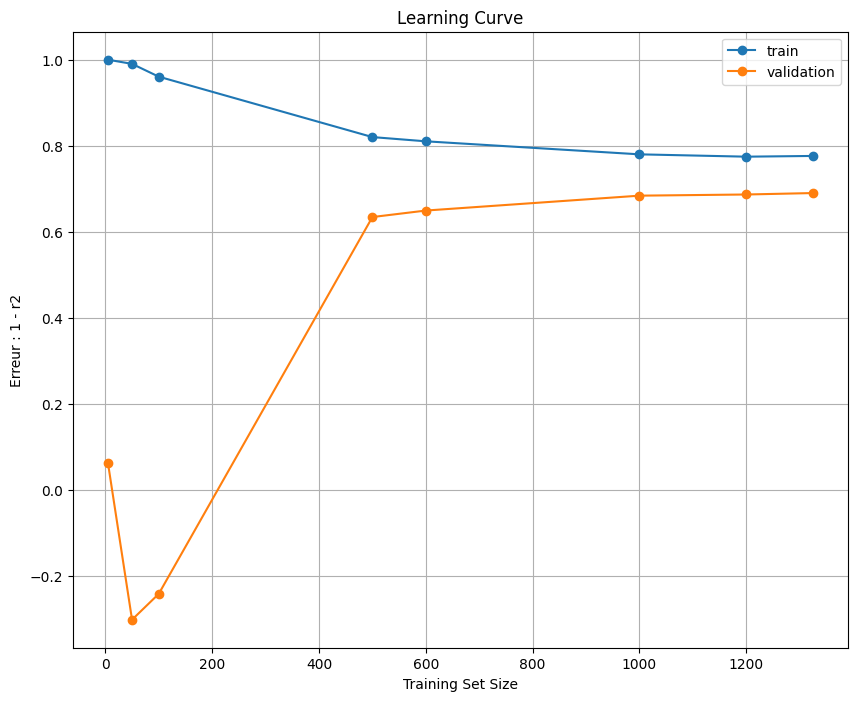

In [104]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train", marker='o')
plt.plot(train_sizes, test_mean, label="validation", marker='o')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Erreur : 1 - r2")
plt.legend(loc="best")
plt.grid(True)
plt.show()

<h1>Lasso</h1>

In [75]:
num_pipeline = Pipeline([
    ('simple_imp', SimpleImputer(strategy="median")),
    ('pt', PowerTransformer(standardize=False)),
    ('MMScaler', MinMaxScaler(feature_range=(0.1, 1), clip = True))
    ])

preprocessor = ColumnTransformer([('num_transform', num_pipeline, num_columns),
                                ('NoTransformer', NoTransformer(), cat_columns),
                                ])

workflow = make_pipeline(preprocessor, 
                         DFTransformer(),
                         ColNameTransformer(),
                         Float16Transformer(),
                         patsylearn.PatsyTransformer(formula, add_intercept=True)
                         )

set_config(display="diagram")

workflow

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('simple_imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('pt',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('MMScaler',
                                                                   MinMaxScaler(clip=True,
                                                                                feature_range=(0.1,
                                                                                               1)))]),
                                                  ['beds', 'baths', 'size']),
                                                 ('NoTransformer',
                                                  NoTransformer(),
                                                  ['zip_code'])])),
                ('dftransformer', DFTransformer()),
                ('colnametransformer', ColNameTransformer()),
                ('float16transformer', Float16Transformer()),
                ('patsytransformer',
                 PatsyTransformer(add_intercept=True,
                                  formula='beds * baths * size * zip_code'))])

In [74]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train  = preprepros(df_train)
df_test  = preprepros(df_test)

y_train = df_train['price']
X_train = df_train.drop(columns = ['price'])
y_test = df_test['price']
X_test = df_test.drop(columns = ['price'])

/tmp/ipykernel_1648/1301583074.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zip_code'] = df['zip_code'].astype(str)


In [76]:
workflow.fit(X_train)
X_train = workflow.transform(X_train)
X_test = workflow.transform(X_test)



In [77]:
X_train = pd.DataFrame(X_train)

In [84]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.117053,0.0,0.0,0.0,0.0,0.000000
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.192759
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.114983,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1652,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.050185
1653,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1654,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.115111


In [91]:
import warnings
warnings.filterwarnings('ignore')
param = {'alpha' : [i/10 for i in range(1, 500, 1)]}
grid_ridge = GridSearchCV(Lasso(max_iter = 1000, precompute = True), param, cv = 3, pre_dispatch = 1).fit(X_train, y_train)
grid_ridge.best_estimator_.score(X_test, y_test)

0.6281221406478277

In [ ]:
lasso = LassoCV

<h1>ElasticNer</h1>